# Analysis of A/B Testing of the Landing Page for a Travel Agency

**Business Task: Analysis of A/B Testing of Two Versions of a Travel Agency's Landing Page**

Task Description:

A travel agency conducted A/B testing to determine which of the two landing page designs on their website is more effective. During the test, users were divided into two groups:

- **Group A**: The control group using the current version of the landing page.
- **Group B**: The test group using the new version of the landing page.

The testing aimed to increase the number of tour sales as well as the average purchase value. The key metrics for analysis include:

1. **Conversion Rate**: The percentage of users who purchased a tour after visiting the landing page.
2. **Average Purchase Value**: The average purchase amount made by users on the site.

Objective:

Identify which landing page (A or B) has a better impact on the key business metrics, and based on statistically significant data, choose the most effective option for further use. The main question is: **Which version of the travel agency's landing page design is more preferable in terms of conversion rate and average purchase value?**


The company offers the following tour packages:

Thailand — 100,000 RUB;
Turkey — 60,000 RUB;
Maldives — 200,000 RUB;
Saint Petersburg — 10,000 RUB;
Kamchatka — 150,000 RUB;

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats

import numpy as np
from statsmodels.stats.proportion import proportion_confint

## Step 1. Data Structure Analysis and Preprocessing

In [2]:
# Loading the Data
data = pd.read_csv('data/ab_data_tourist.csv')

# View the first rows of the dataset
data.head()

# Get information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [3]:
data.isna().sum()

user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64


### Data Transformation and Removing Users Appearing in Both Groups


In [4]:

# Identify users who belong to both groups
user_groups = data.groupby('user_id')['group'].nunique()
double_group_users = user_groups[user_groups > 1].index

# Remove users who appeared in both groups
data = data[~data['user_id'].isin(double_group_users)]


### Converting the Date Column to the Appropriate Data Type

In [5]:

# Convert the 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])


### Checking the Duration of the Experiment

In [6]:

# Check the minimum and maximum dates for each group
data.groupby('group')['date'].agg(['min', 'max'])


,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


## Step 2. Preliminary Analysis of Results

In [7]:

# Grouping data and calculating visits, purchases, and total revenue
group_data = data.groupby('group').agg({
    'user_id': 'count',    # Number of visits
    'purchase': 'sum',     # Number of purchases
    'price': 'sum'         # Total revenue
}).rename(columns={
    'user_id': 'visits', 
    'purchase': 'purchases', 
    'price': 'total_price'
})

# Calculating key metrics:
# 1. Conversion Rate (number of purchases / number of visits)
group_data['conversion_rate'] = group_data['purchases'] / group_data['visits']

# 2. Average Check (total revenue / number of purchases)
group_data['average_check'] = group_data['total_price'] / group_data['purchases']

# Displaying the summary table with results
group_data


,visits,purchases,total_price,conversion_rate,average_check
group,,,,,
A,145307,17487,1417780000,0.120345,81076.228055
B,145381,17290,1533010000,0.118929,88664.545980


Preliminary Conclusion:

Based on these data, it can be inferred that the landing page version in Group A is more effective in terms of conversion rate, as the proportion of purchases relative to the number of visits is higher. However, the landing page version in Group B demonstrates higher performance in terms of average purchase value and total revenue, suggesting it may be better at attracting customers to higher-priced offerings.

This highlights a trade-off between conversion efficiency and revenue generation, warranting further statistical analysis to make a data-driven decision.

## Step 3. Checking the Stabilization of Metrics

In [8]:

# Group the data by date and group
daily_data = data.groupby(['date', 'group']).agg({
    'user_id': 'count',  
    'purchase': 'sum',   
    'price': 'sum'       
}).rename(columns={'user_id': 'visits', 'purchase': 'purchases', 'price': 'total_price'})
daily_data['conversion_rate'] = daily_data['purchases'] / daily_data['visits']  
daily_data['average_check'] = daily_data['total_price'] / daily_data['purchases'] 

daily_data.head()  

visits  purchases  total_price  conversion_rate  \
date       group                                                    
2021-01-02 A        2854        359     29410000         0.125788   
           B        2861        345     29660000         0.120587   
2021-01-03 A        6596        748     62000000         0.113402   
           B        6619        754     65960000         0.113914   
2021-01-04 A        6566        799     64250000         0.121687   

                  average_check  
date       group                 
2021-01-02 A       81922.005571  
           B       85971.014493  
2021-01-03 A       82887.700535  
           B       87480.106101  
2021-01-04 A       80413.016270

### Cumulative Metrics

In [9]:
# Calculation of Cumulative Metrics
daily_data['cum_visits'] = daily_data.groupby('group')['visits'].cumsum()  
daily_data['cum_purchases'] = daily_data.groupby('group')['purchases'].cumsum()  
daily_data['cum_total_price'] = daily_data.groupby('group')['total_price'].cumsum() 
daily_data['cum_conversion_rate'] = daily_data['cum_purchases'] / daily_data['cum_visits']  
daily_data['cum_average_check'] = daily_data['cum_total_price'] / daily_data['cum_purchases']  

# Display cumulative data
daily_data.head()

visits  purchases  total_price  conversion_rate  \
date       group                                                    
2021-01-02 A        2854        359     29410000         0.125788   
           B        2861        345     29660000         0.120587   
2021-01-03 A        6596        748     62000000         0.113402   
           B        6619        754     65960000         0.113914   
2021-01-04 A        6566        799     64250000         0.121687   

                  average_check  cum_visits  cum_purchases  cum_total_price  \
date       group                                                              
2021-01-02 A       81922.005571        2854            359         29410000   
           B       85971.014493        2861            345         29660000   
2021-01-03 A       82887.700535        9450           1107         91410000   
           B       87480.106101        9480           1099         95620000   
2021-01-04 A       80413.016270       16016           1906        155660000   

                  cum_conversion_rate  cum_average_check  
date       group                                          
2021-01-02 A                 0.125788       81922.005571  
           B                 0.120587       85971.014493  
2021-01-03 A                 0.117143       82574.525745  
           B                 0.115928       87006.369427  
2021-01-04 A                 0.119006       81668.415530

### Plotting Cumulative Metrics

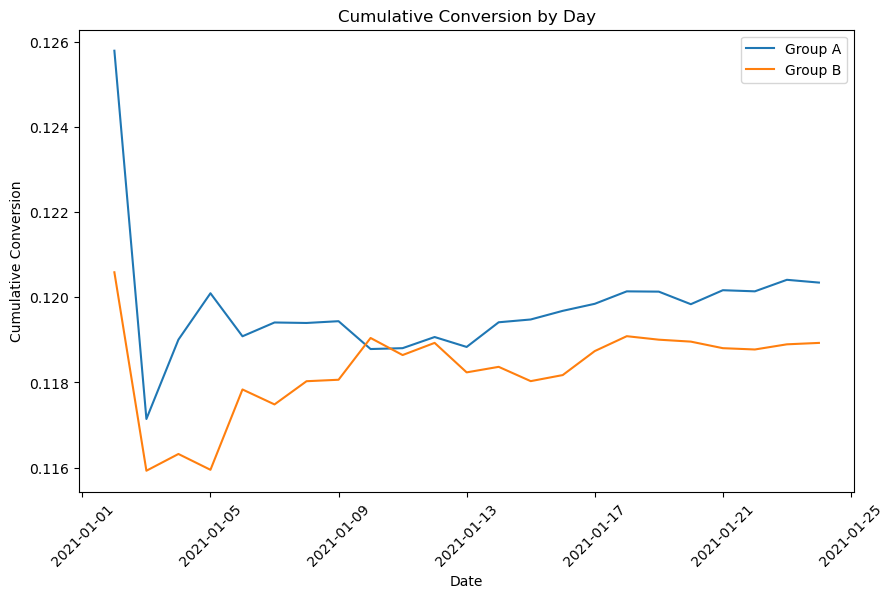

In [10]:
# Cumulative Conversion
plt.figure(figsize=(10, 6))
for group in ['A', 'B']:
    # Filter data by group
    group_data = daily_data.xs(group, level='group')
    plt.plot(group_data['cum_conversion_rate'], label=f'Group {group}')
plt.legend()
plt.title('Cumulative Conversion by Day')
plt.xlabel('Date')
plt.ylabel('Cumulative Conversion')
plt.xticks(rotation=45)
plt.show()

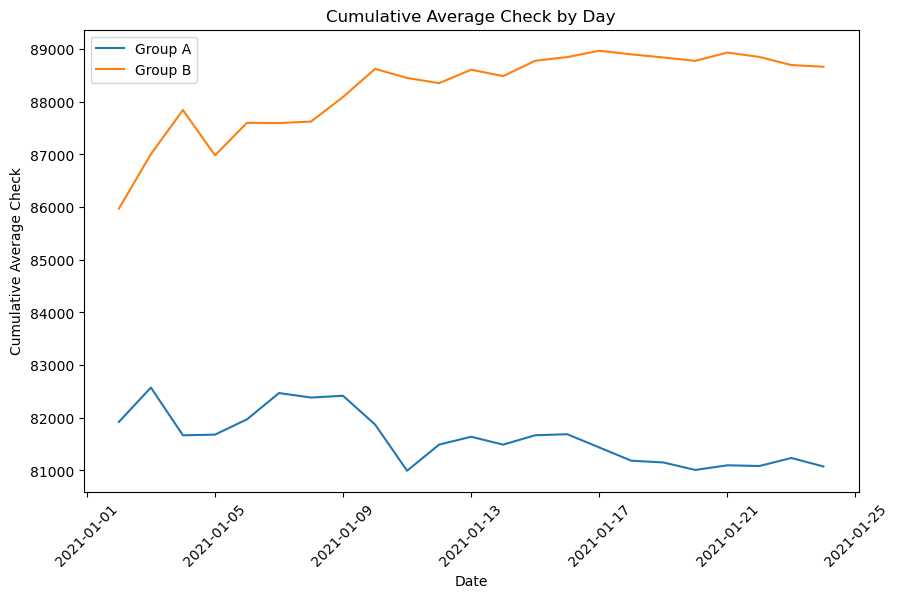

In [11]:

# Cumulative Average Check
plt.figure(figsize=(10, 6))
for group in ['A', 'B']:
    # Filter data by group
    group_data = daily_data.xs(group, level='group')
    plt.plot(group_data['cum_average_check'], label=f'Group {group}')
plt.legend()
plt.title('Cumulative Average Check by Day')
plt.xlabel('Date')
plt.ylabel('Cumulative Average Check')
plt.xticks(rotation=45)
plt.show()


Conclusion:

**Cumulative Conversion:**

- Group A demonstrates a higher cumulative conversion rate (approximately 12.0%) compared to Group B (approximately 11.8%). This indicates that users in Group A make purchases more frequently.
- Both groups stabilized toward the end of the experiment, as shown by the smoothing of the lines on the graph. This suggests that the conversion rate in each group has reached a stable level, and further data collection is unlikely to result in significant changes in outcomes.

**Cumulative Average Check:**

- Group B has a significantly higher average check (approximately 88,000 RUB), while Group A has an average check of around 81,000 RUB.
- The average check also stabilized in both groups toward the end of the experiment. The graph for Group B demonstrates that users are more inclined to purchase higher-priced tours compared to users in Group A.

**Conclusion:**

- Both metrics — conversion rate and average check — stabilized by the end of the experiment, indicating the completion of the A/B test. The data is now ready for statistical analysis and decision-making.
- Group A shows better conversion, but Group B achieves a higher average check and overall revenue.

## Step 4. Statistical Analysis of A/B Test Results

In [12]:
# 1. Hypothesis Formulation
# Null hypothesis: Conversion rates in both groups are equal.
# Alternative hypothesis: Conversion rates in the groups differ.

# 2. Testing data for normality for conversion rates
conversion_A = data[data['group'] == 'A']['purchase']
conversion_B = data[data['group'] == 'B']['purchase']

# Check normality using the Shapiro-Wilk test
shapiro_A = stats.shapiro(conversion_A)
shapiro_B = stats.shapiro(conversion_B)

print(f'Shapiro-Wilk for Group A: {shapiro_A}')
print(f'Shapiro-Wilk for Group B: {shapiro_B}')

# If p-value > 0.05, the data is normally distributed.
# If normality is confirmed for both groups, use a t-test.
if shapiro_A.pvalue > 0.05 and shapiro_B.pvalue > 0.05:
    # t-test to check for differences in conversion rates
    t_stat_conversion, p_value_conversion = stats.ttest_ind(conversion_A, conversion_B)
    print(f't-test for conversion: t-statistic = {t_stat_conversion}, p-value = {p_value_conversion}')
else:
    # If data is not normally distributed, use the Mann-Whitney test
    u_stat_conversion, p_value_conversion = stats.mannwhitneyu(conversion_A, conversion_B)
    print(f'Mann-Whitney test for conversion: U-statistic = {u_stat_conversion}, p-value = {p_value_conversion}')


Shapiro-Wilk for Group A: ShapiroResult(statistic=0.37953467243030925, pvalue=4.010505867307096e-178)
Shapiro-Wilk for Group B: ShapiroResult(statistic=0.3770869938234658, pvalue=2.835895954297904e-178)
Mann-Whitney test for conversion: U-statistic = 10577398242.0, p-value = 0.23940832239601229


c:\Users\mazur\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 145307.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\mazur\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 145381.
  res = hypotest_fun_out(*samples, **kwds)


In [13]:
# 3. Testing data for normality for average purchase value
check_A = data[(data['group'] == 'A') & (data['purchase'] == 1)]['price']
check_B = data[(data['group'] == 'B') & (data['purchase'] == 1)]['price']

# Check normality using the Shapiro-Wilk test
shapiro_A_check = stats.shapiro(check_A)
shapiro_B_check = stats.shapiro(check_B)

print(f'Shapiro-Wilk for average check in Group A: {shapiro_A_check}')
print(f'Shapiro-Wilk for average check in Group B: {shapiro_B_check}')

# If the data is normally distributed, use a t-test.
if shapiro_A_check.pvalue > 0.05 and shapiro_B_check.pvalue > 0.05:
    # t-test to check for differences in average purchase value
    t_stat_check, p_value_check = stats.ttest_ind(check_A, check_B)
    print(f't-test for average check: t-statistic = {t_stat_check}, p-value = {p_value_check}')
else:
    # If data is not normally distributed, use the Mann-Whitney test
    u_stat_check, p_value_check = stats.mannwhitneyu(check_A, check_B)
    print(f'Mann-Whitney test for average check: U-statistic = {u_stat_check}, p-value = {p_value_check}')


Shapiro-Wilk for average check in Group A: ShapiroResult(statistic=0.8617222010315055, pvalue=4.921806060683772e-81)
Shapiro-Wilk for average check in Group B: ShapiroResult(statistic=0.876802108069644, pvalue=3.29687377442508e-78)
Mann-Whitney test for average check: U-statistic = 139547139.0, p-value = 2.825361345286736e-37


c:\Users\mazur\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17487.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\mazur\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17290.
  res = hypotest_fun_out(*samples, **kwds)


### Conclusions:

**Conversion Rate:**
- Based on the Mann-Whitney test, there is no statistically significant difference between the conversion rates in Groups A and B.

**Average Purchase Value:**
- There are statistically significant differences in the average purchase value between Groups A and B. Group B demonstrates a significantly higher average check compared to Group A.

**Summary:**
- The hypothesis of equal conversion rates in both groups is confirmed (the difference is insignificant).
- The hypothesis of equal average purchase values is rejected — Group B significantly outperforms Group A in this metric.


## Step 5. Confidence Intervals

In [14]:

# 1. Confidence Intervals for Conversion in Each Group
# Conversion for Group A
n_A = data[data['group'] == 'A']['purchase'].count()  # Number of users in Group A
p_A = data[data['group'] == 'A']['purchase'].mean()  # Conversion rate for Group A
ci_A_low, ci_A_high = proportion_confint(count=int(p_A * n_A), nobs=n_A, alpha=0.05, method='normal')

# Conversion for Group B
n_B = data[data['group'] == 'B']['purchase'].count()  # Number of users in Group B
p_B = data[data['group'] == 'B']['purchase'].mean()  # Conversion rate for Group B
ci_B_low, ci_B_high = proportion_confint(count=int(p_B * n_B), nobs=n_B, alpha=0.05, method='normal')

print(f'95% Confidence Interval for Conversion Rate (Group A): [{ci_A_low:.4f}, {ci_A_high:.4f}]')
print(f'95% Confidence Interval for Conversion Rate (Group B): [{ci_B_low:.4f}, {ci_B_high:.4f}]')


95% Confidence Interval for Conversion Rate (Group A): [0.1187, 0.1220]
95% Confidence Interval for Conversion Rate (Group B): [0.1173, 0.1206]


In [16]:
# 2. Confidence Interval for the Difference in Conversion Rates
# Standard error of the difference in conversion rates
se_diff = np.sqrt(p_A * (1 - p_A) / n_A + p_B * (1 - p_B) / n_B)

# Difference in conversion rates
diff = p_A - p_B

# 95% confidence interval for the difference in conversion rates
ci_diff_low = diff - 1.96 * se_diff
ci_diff_high = diff + 1.96 * se_diff

print(f'95% Confidence Interval for the Difference in Conversion Rates: [{ci_diff_low:.4f}, {ci_diff_high:.4f}]')


95% Confidence Interval for the Difference in Conversion Rates: [-0.0009, 0.0038]


In [17]:
# 3. Confidence Intervals for Average Purchase Value in Each Group
# Average check for Group A
mean_check_A = data[(data['group'] == 'A') & (data['purchase'] == 1)]['price'].mean()
std_check_A = data[(data['group'] == 'A') & (data['purchase'] == 1)]['price'].std()
n_check_A = data[(data['group'] == 'A') & (data['purchase'] == 1)]['price'].count()

# 95% confidence interval for average check in Group A
ci_check_A_low = mean_check_A - 1.96 * (std_check_A / np.sqrt(n_check_A))
ci_check_A_high = mean_check_A + 1.96 * (std_check_A / np.sqrt(n_check_A))

# Average check for Group B
mean_check_B = data[(data['group'] == 'B') & (data['purchase'] == 1)]['price'].mean()
std_check_B = data[(data['group'] == 'B') & (data['purchase'] == 1)]['price'].std()
n_check_B = data[(data['group'] == 'B') & (data['purchase'] == 1)]['price'].count()

# 95% confidence interval for average check in Group B
ci_check_B_low = mean_check_B - 1.96 * (std_check_B / np.sqrt(n_check_B))
ci_check_B_high = mean_check_B + 1.96 * (std_check_B / np.sqrt(n_check_B))

print(f'95% Confidence Interval for Average Check (Group A): [{ci_check_A_low:.2f}, {ci_check_A_high:.2f}]')
print(f'95% Confidence Interval for Average Check (Group B): [{ci_check_B_low:.2f}, {ci_check_B_high:.2f}]')


95% Confidence Interval for Average Check (Group A): [80137.91, 82014.55]
95% Confidence Interval for Average Check (Group B): [87728.29, 89600.80]


Conclusion:
* **Conversion Rate:** Confidence intervals indicate that the difference in conversion rates between Groups A and B is not significant. The conversion rates in both groups are approximately the same, with differences falling within the range of random fluctuations.

* **Average Purchase Value:** Unlike conversion rates, there is a significant difference in the average purchase value between the groups. Group B has a higher average purchase value, indicating that users in this group chose more expensive tours.

These results support the previous conclusions that while conversion rates are nearly identical across groups, Group B is more profitable due to its significantly higher average purchase value.


## Step 6. Overall Conclusions from A/B Test Results


Overall Conclusion from A/B Test Results

**Answer to the business question:** "Which landing page design for the travel agency's website is more preferable?"

Based on the conducted A/B testing, the following conclusions can be drawn:

1. **Conversion Rate:**
   - Confidence intervals and statistical analysis indicate that **the difference in conversion rates between Groups A and B is not statistically significant**. This means that both landing page versions yield similar results in attracting users to purchase tours. In other words, the landing page design **does not significantly impact conversion rates**.

2. **Average Purchase Value:**
   - On the other hand, there is a **statistically significant difference in average purchase value** between Groups A and B. Group B shows a significantly **higher average purchase value** compared to Group A (a difference of approximately 7,000–8,000 RUB). This suggests that users interacting with Group B's landing page tend to purchase more expensive tours.

#### Final Conclusion:

- **Conversion rates** are similar for both pages, making both landing page versions equally effective in encouraging users to make purchases.
- **Average purchase value** is significantly higher in Group B, making it the preferred option for increasing the company's total revenue.

**Recommendation:**

Based on the results of the A/B test, it can be concluded that **the landing page version for Group B is more preferable**, as it leads to higher purchase amounts, even with similar conversion rates. This allows the company to increase revenue without reducing the number of purchases.

Thus, it is advisable to select and implement **the landing page version for Group B** as the more profitable option.
